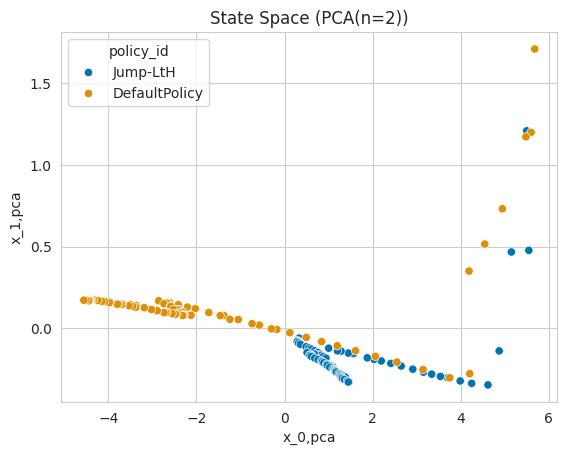

In [16]:
from pathlib import Path
from carps.analysis.gather_data import read_jsonl_content
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import setup_seaborn

setup_seaborn()

rundirs = [
    "../runs_eval/Jump-LtH/BBOB/bbob/2/1/0/1/DACBOEnvLogs.jsonl",
    "../runs_eval/DefaultPolicy/BBOB/bbob/2/1/0/1/DACBOEnvLogs.jsonl",
]

def load_obs(rundirs: list[str]) -> tuple[pd.DataFrame, list[str]]:
    observations = []
    for rundir in rundirs:
        rundir = Path(rundir)
        policy_name = rundir.parts[-8]
        obs = read_jsonl_content(rundir)
        obs_keys = list(obs.iloc[0]["observation"].keys())

        expanded = obs["observation"].apply(pd.Series)
        expanded.columns = obs_keys
        obs = obs.drop(columns="observation").join(expanded)
        obs["policy_id"] = policy_name
        observations.append(obs)
    observations = pd.concat(observations).reset_index(drop=True)
    return observations, obs_keys

def apply_pca_reduction(obs, obs_keys):
    X = obs[obs_keys].to_numpy()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    obs["X_pca"] = list(X_pca)
    expanded = obs["X_pca"].apply(pd.Series)
    expanded.columns = [f"x_{i},pca" for i in range(X_pca.shape[-1])]
    return obs.drop(columns="X_pca").join(expanded)

obs, obs_keys = load_obs(rundirs)
obs = apply_pca_reduction(obs, obs_keys)


fig = plt.figure()
ax = fig.add_subplot(111)

ax = sns.scatterplot(
    data=obs,
    x="x_0,pca",
    y="x_1,pca",
    hue="policy_id"
)

ax.set_title(f"State Space (PCA(n=2))")
plt.show()

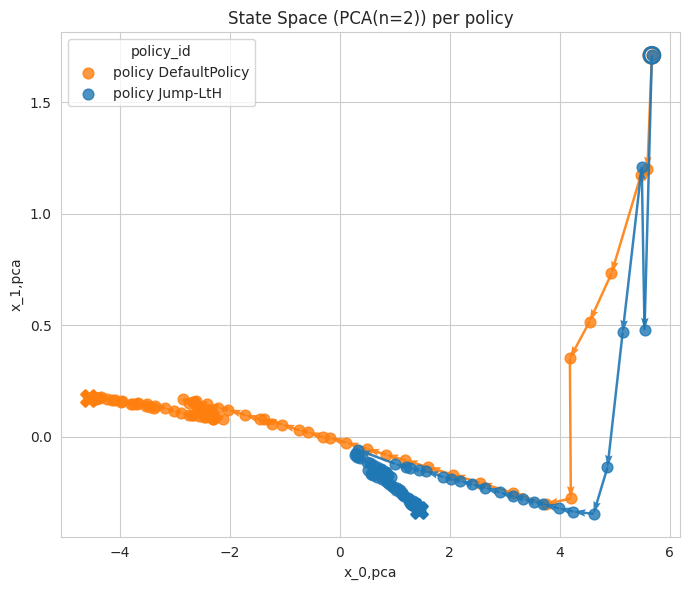

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_time_progression_quiver(
    obs,
    x_col="x_0,pca",
    y_col="x_1,pca",
    time_col="n_trials",
    policy_col="policy_id",
    figsize=(7, 6),
    point_size=60,
    arrow_width=0.003,
):
    """Plot time progression using arrows (quiver), per policy.

    - Points show states
    - Arrows point toward the next time step
    - Start marker: hollow circle
    - End marker: X
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    policies = obs[policy_col].unique()
    palette = sns.color_palette("tab10", len(policies))
    policy_to_color = dict(zip(policies, palette))

    for policy_id, g in obs.groupby(policy_col):
        # Sort by time within policy
        g = g.sort_values(time_col)

        x = g[x_col].values
        y = g[y_col].values

        if len(x) < 2:
            continue

        dx = np.diff(x)
        dy = np.diff(y)

        color = policy_to_color[policy_id]

        # Scatter points
        ax.scatter(
            x,
            y,
            s=point_size,
            color=color,
            alpha=0.8,
            label=f"policy {policy_id}",
        )

        # Quiver arrows (time direction)
        ax.quiver(
            x[:-1],
            y[:-1],
            dx,
            dy,
            angles="xy",
            scale_units="xy",
            scale=1,
            width=arrow_width,
            color=color,
            alpha=0.9,
        )

        # Start marker
        ax.scatter(
            x[0],
            y[0],
            marker="o",
            s=point_size * 2.2,
            facecolors="none",
            edgecolors=color,
            linewidths=2,
        )

        # End marker
        ax.scatter(
            x[-1],
            y[-1],
            marker="X",
            s=point_size * 2.2,
            color=color,
            linewidths=2,
        )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("State Space (PCA(n=2)) per policy")
    ax.legend(title=policy_col)
    fig.tight_layout()
    plt.show()
plot_time_progression_quiver(obs, arrow_width=0.004)